In [31]:
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# convert an array of values into a dataset matrix
def create_dataset(trainX, trainY, look_back=1):
    dataX, dataY = [], []
    for i in range(len(trainX)-look_back-1):
        a = trainX[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(trainY[i + look_back])
    return np.array(dataX), np.array(dataY)

In [32]:
from IPython.display import clear_output
# Live plot for loss during training
# Taken from: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        # Reset the plot to only have the last 100 epochs
        if len(self.x) % 100 == 0:
            self.on_train_begin()
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

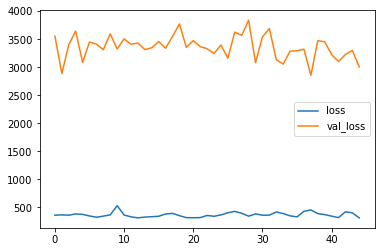

1864/1864 [==============================] - 0s - loss: 311.3410 - val_loss: 3003.2036
Epoch 846/2000
  50/1864 [..............................] - ETA: 0s - loss: 332.6926

KeyboardInterrupt: 

In [38]:

# Extract data from files
latent_val = pd.read_csv('sae_output_5000.csv')
latent_val = np.array(latent_val)[:,2:]
print(latent_val.shape)
y_lazy = pd.read_csv('data/sp500_index_data.csv')['Close Price']
y_train = y_lazy.shift(-1)
y_train = np.array(y_train)
#this means we have an na for the last value training is latent_val, target y_train

# Preparing the datasets with look_back parameters
look_back =4
trainX_fixed = latent_val[:-1]
trainX = trainX_fixed[:round(0.9*len(trainX_fixed))]
testX = trainX_fixed[round(0.9*len(trainX_fixed)):]

trainY_fixed = np.array(y_train[:-1])
trainY = trainY_fixed[:round(0.9*len(trainY_fixed))]
testY = trainY_fixed[round(0.9*len(trainY_fixed)):]

# Delete unnecessary arrays
del trainX_fixed
del trainY_fixed

trainX, trainY = create_dataset(trainX, trainY, look_back)
testX, testY = create_dataset(testX, testY, look_back) 



# create and fit the LSTM network
LEARNING_RATE = 0.005
BATCH_SIZE = 50
EPOCHS = 2000
opti_adam = keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 10)))
#model.add(LSTM(20, input_shape=(look_back, 10)))
model.add(LSTM(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=opti_adam)
model.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCH_SIZE,
          verbose=1, callbacks=[plot_losses], validation_data=(testX, testY))

[[ 2069.25585938]
 [ 2068.98510742]
 [ 2071.69189453]
 [ 2063.12036133]
 [ 2061.11157227]
 [ 2060.27416992]
 [ 2059.77539062]
 [ 2067.51049805]
 [ 2070.68530273]
 [ 2071.328125  ]
 [ 2069.86938477]
 [ 2091.47924805]
 [ 2095.62744141]
 [ 2095.47143555]
 [ 2096.15405273]
 [ 2077.10839844]
 [ 2075.51220703]
 [ 2079.19555664]
 [ 2085.03857422]
 [ 2061.94995117]
 [ 1984.17858887]
 [ 1899.51293945]
 [ 1909.60205078]
 [ 1899.42590332]
 [ 1920.37353516]
 [ 1947.72790527]
 [ 1947.89221191]
 [ 1916.02539062]
 [ 1904.21374512]
 [ 1903.75073242]
 [ 1902.96984863]
 [ 1927.98791504]
 [ 1956.01965332]
 [ 1958.72558594]
 [ 1953.3059082 ]
 [ 2002.97509766]
 [ 2018.18969727]
 [ 2020.60913086]
 [ 1980.56567383]
 [ 1959.90979004]
 [ 1955.48864746]
 [ 1961.03149414]
 [ 1960.30566406]
 [ 1949.0637207 ]
 [ 1945.33227539]
 [ 1944.36743164]
 [ 1948.21191406]
 [ 1981.32202148]
 [ 2005.03393555]
 [ 1996.66381836]
 [ 1998.68554688]
 [ 2009.3059082 ]
 [ 2008.60864258]
 [ 2005.88903809]
 [ 2050.3347168 ]
 [ 2050.72

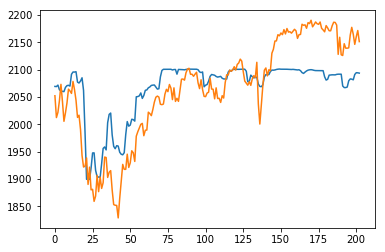

In [39]:
bugger = model.predict(testX)
print(bugger)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(bugger)
plt.plot(testY)
plt.show()

202
202


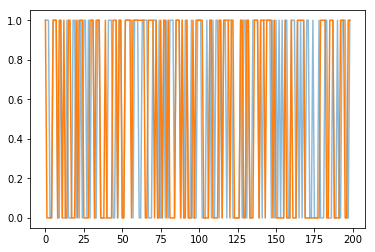

[ 2069.25585938  2068.98510742  2071.69189453  2063.12036133  2061.11157227
  2060.27416992  2059.77539062  2067.51049805  2070.68530273  2071.328125
  2069.86938477  2091.47924805  2095.62744141  2095.47143555  2096.15405273
  2077.10839844  2075.51220703  2079.19555664  2085.03857422  2061.94995117
  1984.17858887  1899.51293945  1909.60205078  1899.42590332  1920.37353516
  1947.72790527  1947.89221191  1916.02539062  1904.21374512  1903.75073242
  1902.96984863  1927.98791504  1956.01965332  1958.72558594  1953.3059082
  2002.97509766  2018.18969727  2020.60913086  1980.56567383  1959.90979004
  1955.48864746  1961.03149414  1960.30566406  1949.0637207   1945.33227539
  1944.36743164  1948.21191406  1981.32202148  2005.03393555  1996.66381836
  1998.68554688  2009.3059082   2008.60864258  2005.88903809  2050.3347168
  2050.72045898  2052.01635742  2057.34960938  2047.37487793  2052.68383789
  2062.22900391  2062.83984375  2066.74584961  2068.33105469  2071.10253906
  2071.63964844 

In [40]:
diff_bugger = np.diff(bugger[:,0])
diff_bugger = [1 if x > 0 else 0 for x in diff_bugger]
diff_trainY = np.diff(testY)
diff_trainY = [1 if x > 0 else 0 for x in diff_trainY]
print(len(diff_trainY))
print(len(diff_bugger))
plt.plot(diff_trainY[1:200], alpha = 0.5)
plt.plot(diff_bugger[1:200])
plt.show()
print(bugger[:,0])

In [41]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(diff_trainY, diff_trainY, labels=[0,1]))
conf_mat = confusion_matrix(diff_bugger, diff_trainY, labels=[0,1])
print(conf_mat)
print("Accuracy price move prediction: {}".format(np.trace(conf_mat) / np.sum(conf_mat)))

[[ 96   0]
 [  0 106]]
[[54 47]
 [42 59]]
Accuracy price move prediction: 0.5594059405940595


In [ ]:
(586+747) / (586+747 + 268 + 262)

In [42]:
def compute_mape(y, y_pred):
    assert len(y) == len(y_pred)
    return np.sum(np.abs((y-y_pred) / y)) / len(y)

compute_mape(bugger, trainY)

AssertionError: 